In [11]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm
import arch
import yfinance as yf

import FinancialMachineLearning as fml

In [7]:
gdp = pd.read_csv('./Data/GDPrate.csv', index_col = 2)
gdp = gdp.Value.astype(float)
gdp.index = pd.date_range(start = '1980-04-01', end = '2022-12-31', freq = 'Q')

unemploy = pd.read_csv('./Data/unemployment.csv', index_col = 2)
unemploy = unemploy.Value.astype(float) * 0.01
unemploy.index = pd.date_range(start = '1953-01-01', end = '2023-03-31', freq = 'M')

interest = pd.read_csv('./Data/interest.csv', index_col = 2)
interest = interest.Value.astype(float) * 0.01
interest.index = pd.to_datetime(interest.index)

inflation = pd.read_csv('./Data/inflation.csv', index_col = 2)
inflation = inflation.Value.astype(float) * 0.01
inflation.index = pd.to_datetime(inflation.index)

In [8]:
interest.index = interest.index.to_period('M')
unemploy.index = unemploy.index.to_period('M')
inflation.index = inflation.index.to_period('M')
gdp.index = gdp.index.to_period('M')

In [9]:
feature_Mat = pd.DataFrame(interest)
feature_Mat.columns = ['interest']
feature_Mat

,interest
DateTime,
1972-10,0.0425
1972-11,0.0425
1972-12,0.0425
1973-01,0.0425
1973-02,0.0425
...,...
2022-12,-0.0010
2023-01,-0.0010
2023-02,-0.0010


In [10]:
feature_Mat = feature_Mat.join(inflation.shift(1).loc['1972-10':], how = 'left')
feature_Mat.columns = ['interest','inflation']
feature_Mat

,interest,inflation
DateTime,,
1972-10,0.0425,0.006
1972-11,0.0425,0.007
1972-12,0.0425,-0.003
1973-01,0.0425,0.007
1973-02,0.0425,0.010
...,...,...
2022-12,-0.0010,0.004
2023-01,-0.0010,0.003
2023-02,-0.0010,0.004


d: 0.05, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.15000000000000002, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.25, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.30000000000000004, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.35000000000000003, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.4, error: maxlag must be less than (nobs/2 - 1 - ntrend)

,adfStat,pVal,lags,nObs,95% conf
0.00,-9.234409,1.645206e-15,1.0,635.0,-2.866102
0.75,1.125865,9.954314e-01,1.0,5.0,-3.929280
0.80,-0.915875,7.826997e-01,1.0,10.0,-3.232950
0.85,-1.747602,4.067682e-01,1.0,19.0,-3.031227
0.90,-2.568721,9.963594e-02,1.0,40.0,-2.937069
0.95,-5.081976,1.523728e-05,1.0,99.0,-2.891208
1.00,-13.219524,1.008372e-24,1.0,634.0,-2.866110


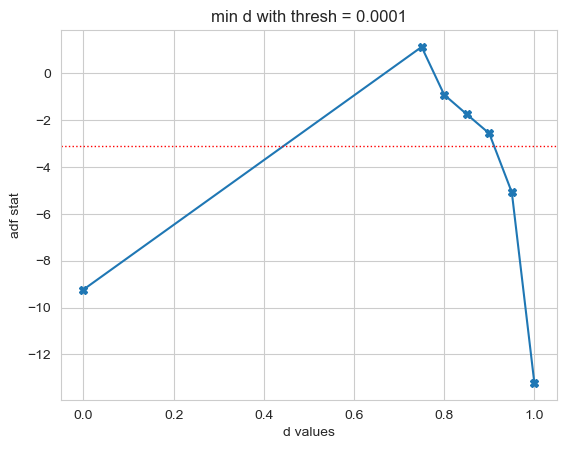

In [12]:
cols = ['adfStat','pVal','lags','nObs','95% conf']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0,1,21):
    try:
        df0 = fml.fracDiff(pd.DataFrame((inflation.cumsum() + 1) * 100), d, thres = 1e-5)
        df0 = sm.tsa.stattools.adfuller(df0, maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df0[:4]) + [df0[4]['5%']]
    except Exception as e:
        print(f'd: {d}, error: {e}')
        continue

f,ax = plt.subplots()
out['adfStat'].plot(ax = ax, marker = 'X')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = 'dotted')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');
display(out)

In [13]:
infla_frac = fml.fracDiff_FFD(pd.DataFrame(inflation.shift(1)), 0.95)
infla_frac

,Value
1976-09,-0.011054
1976-10,0.030397
1976-11,-0.017782
1976-12,-0.006369
1977-01,0.011578
...,...
2022-11,0.000062
2022-12,0.000039
2023-01,-0.000969
2023-02,0.000976


In [14]:
feature_Mat = feature_Mat.join(infla_frac.loc['1972-10':], how = 'left')
feature_Mat.columns = ['interest','inflation','inflation_frac']
feature_Mat

,interest,inflation,inflation_frac
1972-10,0.0425,0.006,NaN
1972-11,0.0425,0.007,NaN
1972-12,0.0425,-0.003,NaN
1973-01,0.0425,0.007,NaN
1973-02,0.0425,0.010,NaN
...,...,...,...
2022-12,-0.0010,0.004,0.000039
2023-01,-0.0010,0.003,-0.000969
2023-02,-0.0010,0.004,0.000976
2023-03,-0.0010,-0.006,-0.009954


In [15]:
feature_Mat = feature_Mat.join(unemploy.loc['1972-10-02':], how = 'left')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment']
feature_Mat

,interest,inflation,inflation_frac,unemployment
1972-10,0.0425,0.006,NaN,0.014
1972-11,0.0425,0.007,NaN,0.014
1972-12,0.0425,-0.003,NaN,0.014
1973-01,0.0425,0.007,NaN,0.013
1973-02,0.0425,0.010,NaN,0.012
...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025
2023-01,-0.0010,0.003,-0.000969,0.024
2023-02,-0.0010,0.004,0.000976,0.026
2023-03,-0.0010,-0.006,-0.009954,0.028


In [16]:
unemploy_frac = fml.fracDiff_FFD(pd.DataFrame(unemploy), 0.85, thres=1e-5)
unemploy_frac

,Value
1967-05,-0.001108
1967-06,0.000831
1967-07,-0.000935
1967-08,-0.000117
1967-09,-0.001061
...,...
2022-11,-0.000979
2022-12,-0.000137
2023-01,-0.001075
2023-02,0.001800


In [17]:
feature_Mat = feature_Mat.join(unemploy_frac.loc['1972-10':], how = 'left')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment','unemployment_frac']
feature_Mat

,interest,inflation,inflation_frac,unemployment,unemployment_frac
1972-10,0.0425,0.006,NaN,0.014,-0.000787
1972-11,0.0425,0.007,NaN,0.014,-0.000004
1972-12,0.0425,-0.003,NaN,0.014,0.000033
1973-01,0.0425,0.007,NaN,0.013,-0.000957
1973-02,0.0425,0.010,NaN,0.012,-0.001104
...,...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025,-0.000137
2023-01,-0.0010,0.003,-0.000969,0.024,-0.001075
2023-02,-0.0010,0.004,0.000976,0.026,0.001800
2023-03,-0.0010,-0.006,-0.009954,0.028,0.002178


In [18]:
stock_code = "^N225"
nikkei = yf.download(stock_code, start="1960-01-01", end="2023-05-31")
nikkei = nikkei['Adj Close'].resample('M').last()
nikkei.index = nikkei.index.to_period('M')
nikkei

[*********************100%***********************]  1 of 1 completed


Date
1965-01     1242.270020
1965-02     1213.069946
1965-03     1132.770020
1965-04     1176.640015
1965-05     1096.599976
               ...     
2023-01    27327.109375
2023-02    27445.560547
2023-03    28041.480469
2023-04    28856.439453
2023-05    30916.310547
Freq: M, Name: Adj Close, Length: 701, dtype: float64

d: 0.05, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.15000000000000002, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.25, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.30000000000000004, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.35000000000000003, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.4, error: maxlag must be less than (nobs/2 - 1 - ntrend)

,adfStat,pVal,lags,nObs,95% conf
0.00,-1.060211,7.306759e-01,1.0,698.0,-2.865690
0.75,-1.117378,7.080921e-01,1.0,7.0,-3.477583
0.80,-2.635347,8.590952e-02,1.0,12.0,-3.154972
0.85,-4.665412,9.768610e-05,1.0,23.0,-2.998500
0.90,-5.407528,3.266050e-06,1.0,48.0,-2.923954
0.95,-8.339217,3.209890e-13,1.0,118.0,-2.886363
1.00,-18.515810,2.111728e-30,1.0,697.0,-2.865696


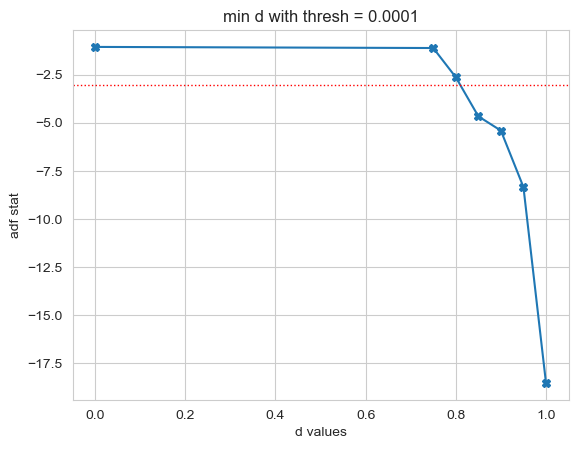

In [19]:
cols = ['adfStat','pVal','lags','nObs','95% conf']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0,1,21):
    try:
        df0 = fml.fracDiff(pd.DataFrame(nikkei), d, thres = 1e-5)
        df0 = sm.tsa.stattools.adfuller(df0, maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df0[:4]) + [df0[4]['5%']]
    except Exception as e:
        print(f'd: {d}, error: {e}')
        continue

f,ax = plt.subplots()
out['adfStat'].plot(ax = ax, marker = 'X')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = 'dotted')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');
display(out)

In [20]:
fracdiff = fml.fracDiff_FFD(pd.DataFrame(nikkei), 0.84)
fracdiff

,Adj Close
1980-03,-140.469177
1980-04,336.055375
1980-05,75.220198
1980-06,79.459108
1980-07,8.500310
...,...
2023-01,1118.616433
2023-02,307.308148
2023-03,757.800294
2023-04,1050.522292


In [21]:
feature_Mat = feature_Mat.join(fracdiff, how = 'left').fillna(method = 'bfill')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment','unemployment_frac','stock']
feature_Mat

,interest,inflation,inflation_frac,unemployment,unemployment_frac,stock
1972-10,0.0425,0.006,-0.011054,0.014,-0.000787,-140.469177
1972-11,0.0425,0.007,-0.011054,0.014,-0.000004,-140.469177
1972-12,0.0425,-0.003,-0.011054,0.014,0.000033,-140.469177
1973-01,0.0425,0.007,-0.011054,0.013,-0.000957,-140.469177
1973-02,0.0425,0.010,-0.011054,0.012,-0.001104,-140.469177
...,...,...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025,-0.000137,-1641.777084
2023-01,-0.0010,0.003,-0.000969,0.024,-0.001075,1118.616433
2023-02,-0.0010,0.004,0.000976,0.026,0.001800,307.308148
2023-03,-0.0010,-0.006,-0.009954,0.028,0.002178,757.800294


In [22]:
feature_Mat = feature_Mat.join(gdp * 0.01, how = 'left').fillna(method = 'bfill')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment','unemployment_frac','stock','gdp_rate']
feature_Mat

,interest,inflation,inflation_frac,unemployment,unemployment_frac,stock,gdp_rate
1972-10,0.0425,0.006,-0.011054,0.014,-0.000787,-140.469177,-0.005
1972-11,0.0425,0.007,-0.011054,0.014,-0.000004,-140.469177,-0.005
1972-12,0.0425,-0.003,-0.011054,0.014,0.000033,-140.469177,-0.005
1973-01,0.0425,0.007,-0.011054,0.013,-0.000957,-140.469177,-0.005
1973-02,0.0425,0.010,-0.011054,0.012,-0.001104,-140.469177,-0.005
...,...,...,...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025,-0.000137,-1641.777084,0.000
2023-01,-0.0010,0.003,-0.000969,0.024,-0.001075,1118.616433,NaN
2023-02,-0.0010,0.004,0.000976,0.026,0.001800,307.308148,NaN
2023-03,-0.0010,-0.006,-0.009954,0.028,0.002178,757.800294,NaN


<AxesSubplot:>

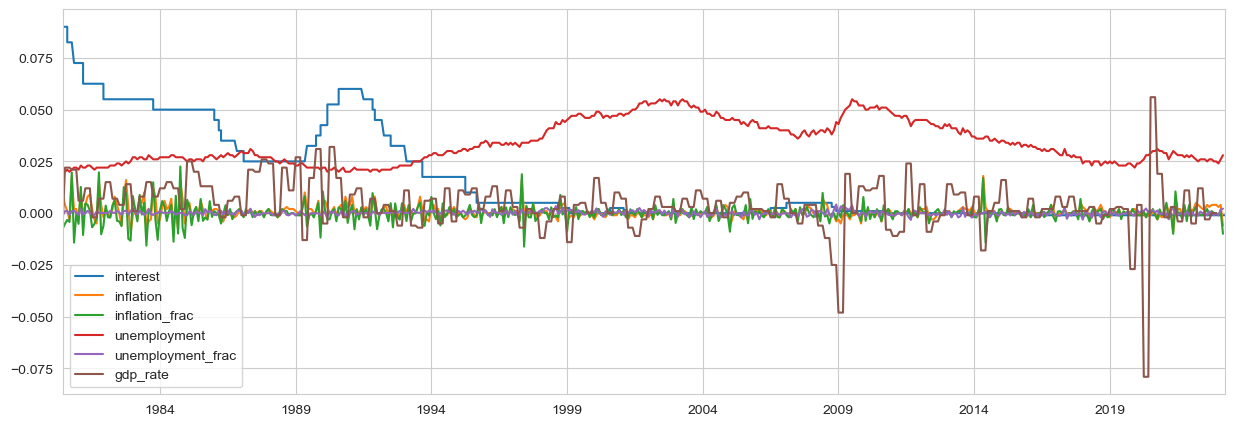

In [23]:
feature_Mat.loc['1980-06':].iloc[:,[0,1,2,3,4,6]].plot(figsize = (15,5))

In [24]:
Data = feature_Mat.loc['1980-06':'2022-12']

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

X = Data.iloc[:,:-1]
y = Data['gdp_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)

model = RandomForestRegressor(n_estimators = 10000,
                              random_state = 42,
                              criterion = 'mae',
                              bootstrap = False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Test MSE: {mse:.3f}')
print(f'Test MSE: {mae:.3f}')


Test MSE: 0.000
Test MSE: 0.013


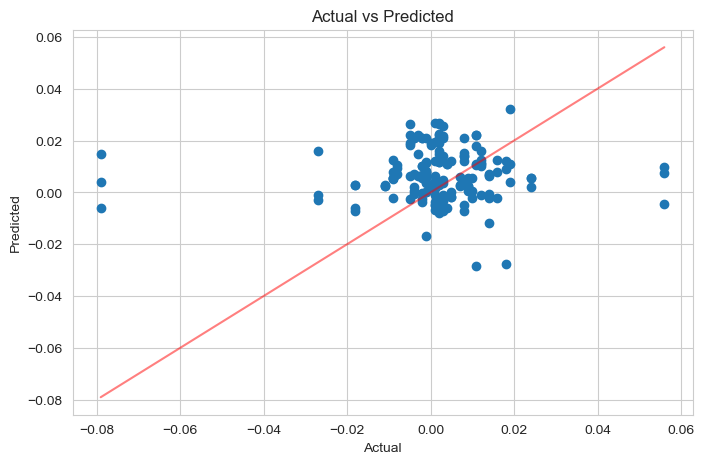

In [37]:
predictions = model.predict(X_test)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red', alpha = 0.5)
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [72]:
yt = pd.DataFrame(y_test, index = Data.index[-164:])
pred_y = pd.DataFrame(predictions, index = Data.index[-164:])
ytrain = pd.DataFrame(y_train, index = Data.index[:-164])

In [76]:
pred_y.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=164, freq=None)

In [74]:
yt.index = yt.index.to_timestamp()
pred_y.index = pred_y.index.to_timestamp()
ytrain.index = ytrain.index.to_timestamp()

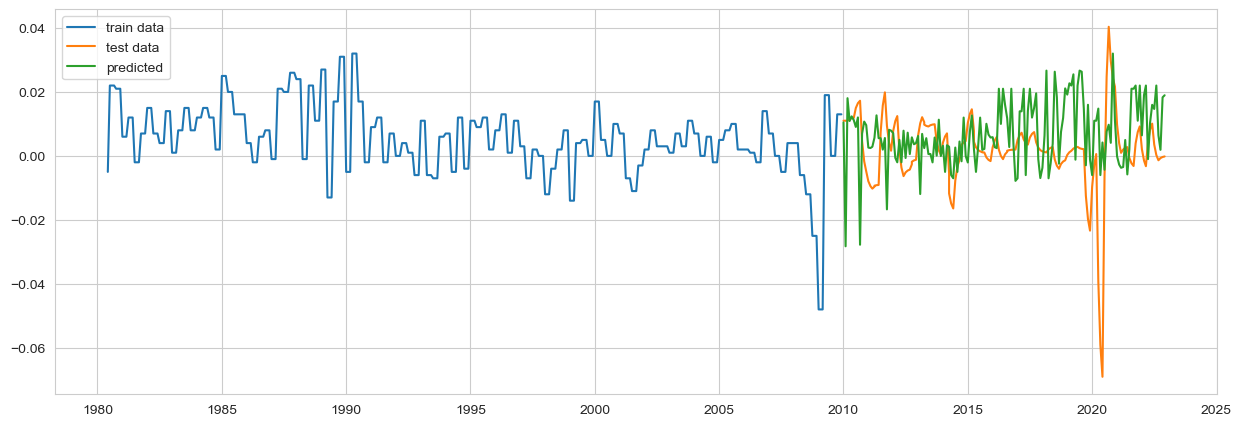

In [95]:
plt.figure(figsize=(15,5))
plt.plot(ytrain, label = 'train data')
plt.plot(yt.ewm(span=3).mean(), label = 'test data')
plt.plot(pred_y, label = 'predicted')
plt.legend()
plt.show()

statsmodels

In [96]:
import statsmodels.api as sm
y = Data['gdp_rate']
X = Data.drop(['gdp_rate'], axis = 1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               gdp_rate   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     10.25
Date:                Sun, 28 May 2023   Prob (F-statistic):           9.22e-11
Time:                        00:38:31   Log-Likelihood:                 1634.2
No. Observations:                 546   AIC:                            -3254.
Df Residuals:                     539   BIC:                            -3224.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0020      0.003     -0.736      0.462      -0.007       0.003
interest              0.2015      0.032      6.385      0.000       0.140       0.264
inflation            -0.2694      0.244     -1.105      0.270      -0.748       0.209
inflation_frac        0.1566      0.178      0.882      0.378      -0.192       0.506
unemployment          0.0950      0.070      1.364      0.173      -0.042       0.232
unemployment_frac    -1.2805      0.491     -2.607      0.009      -2.245      -0.315
stock               1.23e-06   4.75e-07      2.587      0.010    2.96e-07    2.16e-06
==============================================================================
Omnibus:                      220.274   Durbin-Watson:                   0.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3441.649
Skew:                          -1.336   Prob(JB):                         0.00
Kurtosis:                      15.006   Cond. No.                     1.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Residual vs. Normal')

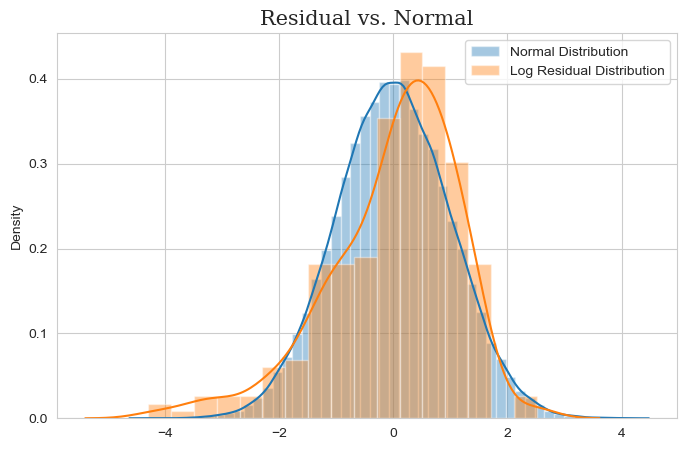

In [99]:
fig, ax1 = plt.subplots(figsize=(8,5), dpi=100)
sns.distplot(np.random.normal(size=100000), kde = True, ax = ax1, label = 'Normal Distribution')
sns.distplot(np.log(results.resid) - np.log(results.resid).mean() ,
             kde = True, rug = False , ax = ax1, label = 'Log Residual Distribution')
plt.legend()
plt.title('Residual vs. Normal', fontsize = 15, fontfamily = 'Serif')

Text(0, 0.5, 'predicted GDP rate')

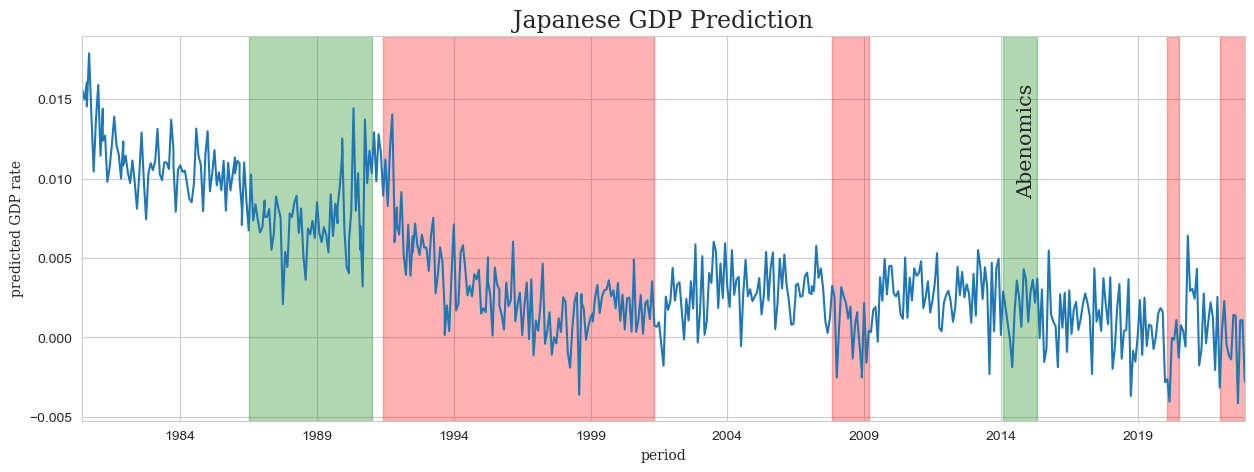

In [114]:
results.fittedvalues.plot(figsize = (15,5))
plt.axvspan('1991-06-01', '2001-05-31', color = 'red', alpha = 0.3)
plt.axvspan('2007-11-01', '2009-03-31', color = 'red', alpha = 0.3)
plt.axvspan('2014-02-01', '2015-05-31', color = 'green', alpha = 0.3)
plt.axvspan('1986-07-01', '1991-01-31', color = 'green', alpha = 0.3)
plt.axvspan('2020-02-01', '2020-07-31', color = 'red', alpha = 0.3)
plt.axvspan('2022-01-01', '2023-04-30', color = 'red', alpha = 0.3)
plt.text(535, 0.009, 'Abenomics', ha = 'left', fontsize = 15, fontfamily = 'Serif', rotation = 90)
plt.title('Japanese GDP Prediction', fontfamily = 'Serif', fontsize = 17)
plt.xlabel('period', fontfamily = 'Serif', fontsize = 10)
plt.ylabel('predicted GDP rate', fontfamily = 'Serif', fontsize = 10)